In [1]:
import sys, os
DMOL_DIR = "/Users/Henryye/research/shaf/DMOL"
sys.path.append(os.path.join(DMOL_DIR, "utils"))

from ml_utils import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# LDA
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel
from pprint import pprint


# For viz
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../data/open_ended_responses.csv")

In [3]:
def prepare_lda(text_list):
    preprocessed_text = [nlp_preprocess(act).split() for act in text_list]
    id2word = gensim.corpora.Dictionary(preprocessed_text)
    # Gensim Count Vector
    bow_corpus = [id2word.doc2bow(act) for act in preprocessed_text]
    # for i,c in enumerate(bow_corpus):
    #     if len(c) >= 5:
    #         print("Original sentence:  {}".format(oact[i]))
    #         for i in c:
    #             print("word {} appeared {} times".format(word_dictionary[i[0]], i[1]))
    #         break

    # Convert Count to td-idf score
    tfidf = models.TfidfModel(bow_corpus)
    corpus_tfidf = tfidf[bow_corpus]
    return preprocessed_text, id2word, corpus_tfidf
    
def find_num_topics(num_topic_min, num_topic_max, text, id2word, corpus, verbose = True):
# lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=id2word, passes=2, workers=2)
    coherence_score = []
    for num_topics in range(num_topic_min, num_topic_max + 1):
        lda_model_tfidf = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=id2word, random_state = 100,  
                                                     chunksize=50,passes=50, per_word_topics = True, workers = 5)
        coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=text, dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        if verbose:
            print('num_topics = {}   \tCoherence Score:  {}\tPerplexity: {}'.format(num_topics, coherence_lda, lda_model_tfidf.log_perplexity(corpus)))
        coherence_score.append(coherence_lda)
    
    plt.figure(figsize = (13.8, 8))
    sns.set_style('whitegrid')
    plt.plot(list(range(num_topic_min, num_topic_max + 1)), coherence_score, '-o')
    plt.title("Coherence Score vs Num Topics",fontsize=16)
    plt.xlabel("Num Topics", fontsize=14)
    plt.ylabel("Coherence Score", fontsize=14)
    plt.xticks(list(range(num_topic_min, num_topic_max + 1)))
    plt.tick_params(labelsize=14)
    plt.show()
    
    return coherence_score

def check_topics(num_topics, texts, id2word, corpus):
    lda_model_tfidf = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=id2word, 
                                                 random_state = 100,  chunksize=50,
                                                 passes=50, per_word_topics = True, workers = 5)
    coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('num_topics = {} \t Coherence Score:  {} \t Perplexity: {}\n'.format(num_topics, coherence_lda, lda_model_tfidf.log_perplexity(corpus)))
    for idx, topic in lda_model_tfidf.print_topics(-1):
        print('Topics: {} \nWords: {}'.format(idx, topic))
    
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model_tfidf, corpus, id2word)
    return vis

# Other Activities Analysis

In [4]:
oact_col_names = [c for c in df.columns if "oact" in c and "compx" not in c]
oact = [act for c in oact_col_names for act in df[df[c].notnull()].loc[1:, c]]
preprocessed_oact, id2word_oact, corpus_tfidf_oact = prepare_lda(oact)
print("Num of Documents:  ", len(preprocessed_oact))
print("Num of Uniq Words:  ", len(id2word_oact))

Num of Documents:   2293
Num of Uniq Words:   586


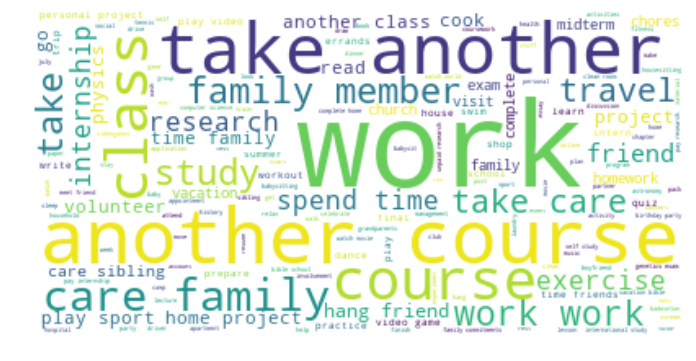

In [5]:
generate_wordcloud(preprocessed_oact)

num_topics = 1   	Coherence Score:  0.6946918516600661	Perplexity: -5.216405228046397
num_topics = 2   	Coherence Score:  0.7039084922119856	Perplexity: -5.369428493759303
num_topics = 3   	Coherence Score:  0.7433182813906942	Perplexity: -5.539737676396633
num_topics = 4   	Coherence Score:  0.7319526263974623	Perplexity: -5.5940014843182775
num_topics = 5   	Coherence Score:  0.7463707494003813	Perplexity: -5.656200350206016
num_topics = 6   	Coherence Score:  0.731439669595832	Perplexity: -5.75420690909346
num_topics = 7   	Coherence Score:  0.7201668582869589	Perplexity: -5.788366665371358
num_topics = 8   	Coherence Score:  0.718121122240212	Perplexity: -5.863401336650892
num_topics = 9   	Coherence Score:  0.7094595094657404	Perplexity: -6.116650459426723
num_topics = 10   	Coherence Score:  0.7028388834629316	Perplexity: -6.1986493527949635
num_topics = 11   	Coherence Score:  0.7125162420462364	Perplexity: -6.312715565266068


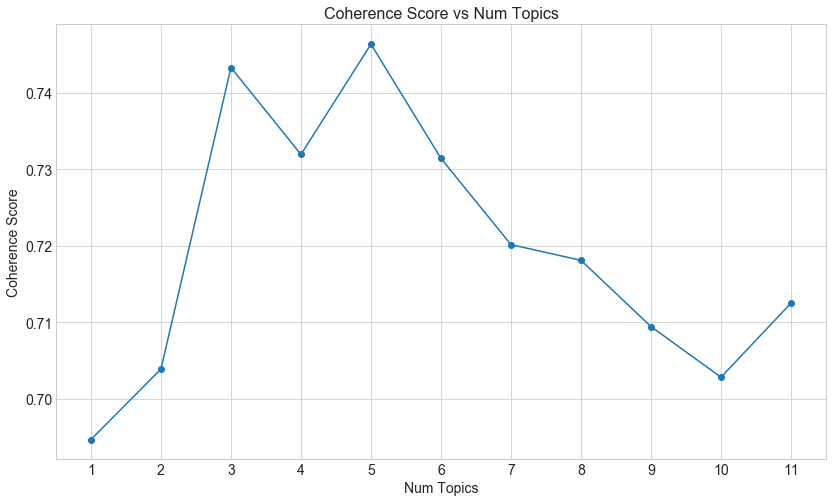

In [6]:
coherence_scores_oact = find_num_topics(1, 11, preprocessed_oact, id2word_oact, corpus_tfidf_oact)

In [7]:
check_topics(3, preprocessed_oact, id2word_oact, corpus_tfidf_oact)

num_topics = 3 	 Coherence Score:  0.7484990445208896 	 Perplexity: -5.523010141723529

Topics: 0 
Words: 0.225*"work" + 0.098*"family" + 0.060*"care" + 0.045*"project" + 0.043*"research" + 0.035*"members" + 0.018*"personal" + 0.017*"chores" + 0.016*"go" + 0.015*"complete"
Topics: 1 
Words: 0.025*"physics" + 0.021*"read" + 0.018*"vacation" + 0.017*"intern" + 0.016*"errands" + 0.016*"study" + 0.016*"final" + 0.014*"school" + 0.014*"quiz" + 0.013*"self"
Topics: 2 
Words: 0.100*"course" + 0.084*"take" + 0.080*"another" + 0.058*"class" + 0.035*"friends" + 0.033*"time" + 0.031*"exercise" + 0.029*"internship" + 0.028*"travel" + 0.025*"spend"


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.281613 -0.094567       1        1  39.243214
0     -0.239797 -0.154489       2        1  32.775745
1     -0.041816  0.249056       3        1  27.981047, topic_info=    Category        Freq         Term       Total  loglift  logprob
9    Default  217.000000         work  217.000000  30.0000  30.0000
26   Default  115.000000       course  115.000000  29.0000  29.0000
27   Default   95.000000       family   95.000000  28.0000  28.0000
3    Default   98.000000         take   98.000000  27.0000  27.0000
16   Default   92.000000      another   92.000000  26.0000  26.0000
37   Default   58.000000         care   58.000000  25.0000  25.0000
2    Default   67.000000        class   67.000000  24.0000  24.0000
12   Default   44.000000      project   44.000000  23.0000  23.0000
13   Default   42.000000     research   42.000000  22.0000  22.0000
79   Default   34.000000      members   34.000000  21.0000  21.0000
19   Default   40.000000      friends   40.000000  20.0000  20.0000
117  Default   38.000000         time   38.000000  19.0000  19.0000
0    Default   36.000000     exercise   36.000000  18.0000  18.0000
5    Default   33.000000   internship   33.000000  17.0000  17.0000
146  Default   33.000000       travel   33.000000  16.0000  16.0000
59   Default   21.000000      physics   21.000000  15.0000  15.0000
150  Default   29.000000        spend   29.000000  14.0000  14.0000
22   Default   26.000000         play   26.000000  13.0000  13.0000
20   Default   26.000000         hang   26.000000  12.0000  12.0000
10   Default   25.000000         cook   25.000000  11.0000  11.0000
35   Default   17.000000         read   17.000000  10.0000  10.0000
62   Default   25.000000         home   25.000000   9.0000   9.0000
68   Default   22.000000        sport   22.000000   8.0000   8.0000
38   Default   22.000000    volunteer   22.000000   7.0000   7.0000
11   Default   17.000000     personal   17.000000   6.0000   6.0000
138  Default   15.000000     vacation   15.000000   5.0000   5.0000
119  Default   17.000000       chores   17.000000   4.0000   4.0000
39   Default   14.000000       intern   14.000000   3.0000   3.0000
237  Default   14.000000      errands   14.000000   2.0000   2.0000
208  Default   16.000000           go   16.000000   1.0000   1.0000
..       ...         ...          ...         ...      ...      ...
138   Topic3   14.627961     vacation   15.178331   1.2367  -4.0321
39    Topic3   14.025253       intern   14.574022   1.2353  -4.0742
237   Topic3   13.506117      errands   14.056352   1.2337  -4.1119
249   Topic3   12.879081        final   13.454341   1.2299  -4.1594
137   Topic3   11.941529       school   12.497192   1.2282  -4.2350
64    Topic3   11.351660         quiz   11.906602   1.2259  -4.2857
171   Topic3   10.937580         self   11.505734   1.2230  -4.3228
479   Topic3    9.430805      fitness    9.981467   1.2169  -4.4711
88    Topic3    9.342845        dance    9.890773   1.2167  -4.4804
98    Topic3    8.947209         meet    9.503527   1.2133  -4.5237
105   Topic3    8.744448       tennis    9.307647   1.2112  -4.5466
199   Topic3    8.734109   activities    9.300473   1.2108  -4.5478
129   Topic3    8.422073      prepare    8.981327   1.2094  -4.5842
121   Topic3    8.148132       online    8.713602   1.2065  -4.6172
4     Topic3    7.809189         swim    8.359742   1.2055  -4.6597
281   Topic3    7.671651  babysitting    8.221820   1.2044  -4.6775
102   Topic3    7.648858        learn    8.198637   1.2042  -4.6805
89    Topic3    7.427008     practice    7.977880   1.2021  -4.7099
31    Topic3    7.453168        party    8.019030   1.2005  -4.7064
90    Topic3    6.949361       friend    7.517253   1.1951  -4.7764
124   Topic3    6.770216       unpaid    7.339452   1.1929  -4.8025
364   Topic3    7.209103         july    7.866955   1.1863  -4.7397
56    Topic3   

In [8]:
check_topics(4, preprocessed_oact, id2word_oact, corpus_tfidf_oact)

num_topics = 4 	 Coherence Score:  0.7371562468413411 	 Perplexity: -5.5683152614416755

Topics: 0 
Words: 0.146*"family" + 0.093*"care" + 0.059*"research" + 0.056*"members" + 0.027*"personal" + 0.015*"project" + 0.015*"visit" + 0.014*"house" + 0.014*"workout" + 0.014*"watch"
Topics: 1 
Words: 0.156*"course" + 0.133*"take" + 0.124*"another" + 0.023*"physics" + 0.021*"read" + 0.018*"vacation" + 0.016*"study" + 0.015*"siblings" + 0.014*"intern" + 0.012*"school"
Topics: 2 
Words: 0.085*"class" + 0.049*"friends" + 0.044*"internship" + 0.043*"time" + 0.043*"travel" + 0.039*"exercise" + 0.038*"project" + 0.035*"play" + 0.031*"home" + 0.031*"spend"
Topics: 3 
Words: 0.379*"work" + 0.041*"volunteer" + 0.034*"cook" + 0.022*"chores" + 0.016*"write" + 0.014*"errands" + 0.014*"prepare" + 0.014*"learn" + 0.012*"management" + 0.011*"sibling"


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.245562  0.191189       1        1  28.485870
2      0.247528  0.140362       2        1  27.342903
0      0.070524 -0.082711       3        1  23.283464
3     -0.072490 -0.248839       4        1  20.887762, topic_info=    Category        Freq        Term       Total  loglift  logprob
9    Default  234.000000        work  234.000000  30.0000  30.0000
26   Default  131.000000      course  131.000000  29.0000  29.0000
27   Default  100.000000      family  100.000000  28.0000  28.0000
3    Default  112.000000        take  112.000000  27.0000  27.0000
16   Default  104.000000     another  104.000000  26.0000  26.0000
37   Default   64.000000        care   64.000000  25.0000  25.0000
2    Default   69.000000       class   69.000000  24.0000  24.0000
13   Default   41.000000    research   41.000000  23.0000  23.0000
79   Default   39.000000     members   39.000000  22.0000  22.0000
19   Default   40.000000     friends   40.000000  21.0000  21.0000
5    Default   35.000000  internship   35.000000  20.0000  20.0000
117  Default   35.000000        time   35.000000  19.0000  19.0000
146  Default   34.000000      travel   34.000000  18.0000  18.0000
38   Default   26.000000   volunteer   26.000000  17.0000  17.0000
0    Default   31.000000    exercise   31.000000  16.0000  16.0000
22   Default   28.000000        play   28.000000  15.0000  15.0000
10   Default   21.000000        cook   21.000000  14.0000  14.0000
62   Default   26.000000        home   26.000000  13.0000  13.0000
150  Default   25.000000       spend   25.000000  12.0000  12.0000
20   Default   25.000000        hang   25.000000  11.0000  11.0000
68   Default   25.000000       sport   25.000000  10.0000  10.0000
12   Default   41.000000     project   41.000000   9.0000   9.0000
11   Default   18.000000    personal   18.000000   8.0000   8.0000
59   Default   20.000000     physics   20.000000   7.0000   7.0000
18   Default   35.000000       study   35.000000   6.0000   6.0000
119  Default   13.000000      chores   13.000000   5.0000   5.0000
35   Default   17.000000        read   17.000000   4.0000   4.0000
243  Default   15.000000      church   15.000000   3.0000   3.0000
138  Default   15.000000    vacation   15.000000   2.0000   2.0000
66   Default   14.000000    complete   14.000000   1.0000   1.0000
..       ...         ...         ...         ...      ...      ...
38    Topic4   25.398630   volunteer   26.023825   1.5417  -3.1880
10    Topic4   20.734465        cook   21.361801   1.5362  -3.3909
119   Topic4   13.328760      chores   13.957494   1.5199  -3.8327
201   Topic4    9.667433       write   10.295950   1.5030  -4.1539
237   Topic4    8.689537     errands    9.317681   1.4962  -4.2605
129   Topic4    8.529601     prepare    9.163404   1.4943  -4.2791
102   Topic4    8.382011       learn    9.010182   1.4937  -4.2966
116   Topic4    7.328466  management    7.953856   1.4841  -4.4309
114   Topic4    6.534818     sibling    7.165358   1.4739  -4.5455
109   Topic4    5.694973  videogames    6.319651   1.4619  -4.6831
29    Topic4    5.682285        baby    6.310201   1.4612  -4.6853
479   Topic4    5.492588     fitness    6.116893   1.4584  -4.7193
214   Topic4    5.160209       essay    5.787968   1.4512  -4.7817
8     Topic4    4.728192  experiment    5.352401   1.4420  -4.8691
172   Topic4    4.652504       tutor    5.276739   1.4401  -4.8853
325   Topic4    4.642653        test    5.269174   1.4394  -4.8874
410   Topic4    4.574027     program    5.203088   1.4371  -4.9023
25    Topic4    4.399912       music    5.028837   1.4324  -4.9411
341   Topic4    3.320329   strategic    3.945078   1.3936  -5.2226
168   Topic4    3.233556       train    3.865993   1.3874  -5.2491
333   Topic4    3.176003    hospital    3.803479   1.3857  -5.2670
403   Topic4    3.076526      search    3.700810   1.3813  -5.2989
189   Topic4   

# Course-related activities Analysis

In [9]:
cact_col_names = ["dcact{}".format(i) for i in range(1, 31)]
cact = [act for c in cact_col_names for act in df[df[c].notnull()].loc[1:, c]]
preprocessed_cact, id2word_cact, corpus_tfidf_cact = prepare_lda(cact)
print("Num of Documents:  ", len(preprocessed_cact))
print("Num of Uniq Words:  ", len(id2word_cact))

Num of Documents:   805
Num of Uniq Words:   133


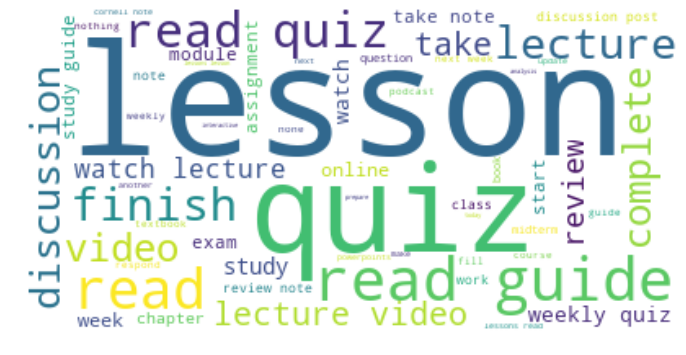

In [10]:
generate_wordcloud(preprocessed_cact)

num_topics = 1   	Coherence Score:  0.45746656300762273	Perplexity: -3.8012949818877186
num_topics = 2   	Coherence Score:  0.6332808458352845	Perplexity: -4.015342827974098
num_topics = 3   	Coherence Score:  0.6758009481744728	Perplexity: -4.1954685645586975
num_topics = 4   	Coherence Score:  0.6886181468475039	Perplexity: -4.413587895188995
num_topics = 5   	Coherence Score:  0.7169290036192534	Perplexity: -4.516435025154086
num_topics = 6   	Coherence Score:  0.6638370050459491	Perplexity: -4.554357843945142
num_topics = 7   	Coherence Score:  0.6851385252139982	Perplexity: -4.578628565291871
num_topics = 8   	Coherence Score:  0.691580410495054	Perplexity: -4.638708022062122
num_topics = 9   	Coherence Score:  0.6670363254554181	Perplexity: -4.762488910134088
num_topics = 10   	Coherence Score:  0.6598416808845647	Perplexity: -4.771149141380954
num_topics = 11   	Coherence Score:  0.6661849548226907	Perplexity: -4.833416034338548


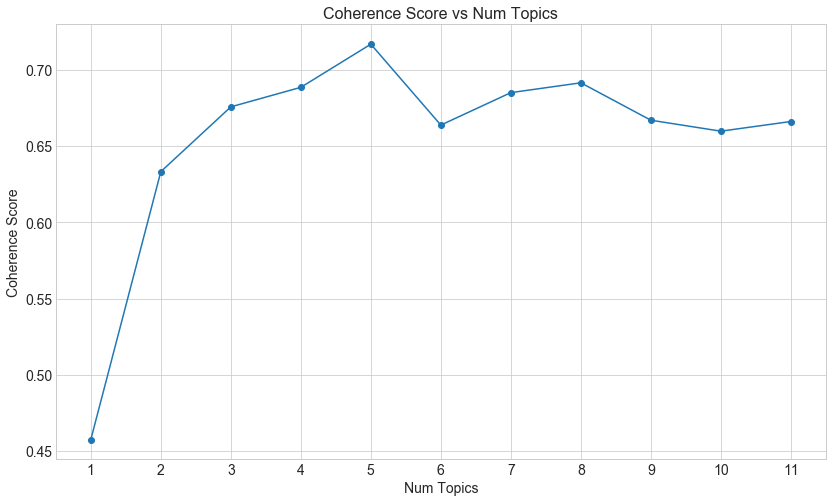

In [11]:
coherence_scores_cact = find_num_topics(1, 11, preprocessed_cact, id2word_cact, corpus_tfidf_cact)

In [12]:
check_topics(3, preprocessed_cact, id2word_cact, corpus_tfidf_cact)

num_topics = 3 	 Coherence Score:  0.6790449992364452 	 Perplexity: -4.208971991692514

Topics: 0 
Words: 0.433*"quiz" + 0.037*"post" + 0.036*"exam" + 0.023*"podcast" + 0.022*"class" + 0.021*"work" + 0.019*"read" + 0.018*"advance" + 0.016*"textbook" + 0.015*"cornell"
Topics: 1 
Words: 0.186*"lecture" + 0.079*"finish" + 0.079*"weekly" + 0.077*"video" + 0.075*"review" + 0.067*"videos" + 0.063*"study" + 0.060*"watch" + 0.025*"lesson" + 0.023*"assignments"
Topics: 2 
Words: 0.222*"read" + 0.151*"lesson" + 0.119*"guide" + 0.080*"discussion" + 0.074*"take" + 0.057*"complete" + 0.039*"week" + 0.027*"online" + 0.027*"lessons" + 0.022*"module"


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.225661 -0.194132       1        1  40.137627
1     -0.289222 -0.089201       2        1  34.592007
0      0.063561  0.283333       3        1  25.270361, topic_info=    Category        Freq         Term       Total  loglift  logprob
2    Default  122.000000         quiz  122.000000  30.0000  30.0000
23   Default   72.000000      lecture   72.000000  29.0000  29.0000
4    Default  104.000000         read  104.000000  28.0000  28.0000
6    Default   53.000000        guide   53.000000  27.0000  27.0000
5    Default   77.000000       lesson   77.000000  26.0000  26.0000
21   Default   31.000000       finish   31.000000  25.0000  25.0000
44   Default   31.000000       weekly   31.000000  24.0000  24.0000
30   Default   36.000000   discussion   36.000000  23.0000  23.0000
49   Default   30.000000        video   30.000000  22.0000  22.0000
25   Default   29.000000       review   29.000000  21.0000  21.0000
14   Default   33.000000         take   33.000000  20.0000  20.0000
35   Default   26.000000       videos   26.000000  19.0000  19.0000
9    Default   25.000000        study   25.000000  18.0000  18.0000
24   Default   23.000000        watch   23.000000  17.0000  17.0000
12   Default   25.000000     complete   25.000000  16.0000  16.0000
67   Default   10.000000         post   10.000000  15.0000  15.0000
13   Default   10.000000         exam   10.000000  14.0000  14.0000
52   Default   18.000000         week   18.000000  13.0000  13.0000
46   Default   12.000000       online   12.000000  12.0000  12.0000
56   Default   12.000000      lessons   12.000000  11.0000  11.0000
50   Default    7.000000      podcast    7.000000  10.0000  10.0000
1    Default    6.000000        class    6.000000   9.0000   9.0000
10   Default    9.000000  assignments    9.000000   8.0000   8.0000
19   Default    6.000000         work    6.000000   7.0000   7.0000
45   Default    9.000000  discussions    9.000000   6.0000   6.0000
29   Default   10.000000       module   10.000000   5.0000   5.0000
122  Default    5.000000      advance    5.000000   4.0000   4.0000
27   Default    5.000000     textbook    5.000000   3.0000   3.0000
43   Default    7.000000        start    7.000000   2.0000   2.0000
100  Default    4.000000       update    4.000000   1.0000   1.0000
..       ...         ...          ...         ...      ...      ...
13    Topic3   10.219131         exam   10.804682   1.3198  -3.3137
1     Topic3    6.273612        class    6.857436   1.2866  -3.8016
50    Topic3    6.413429      podcast    7.011980   1.2863  -3.7796
19    Topic3    5.848353         work    6.436546   1.2797  -3.8718
122   Topic3    5.105881      advance    5.679307   1.2691  -4.0076
27    Topic3    4.580545     textbook    5.157005   1.2570  -4.1161
99    Topic3    4.328129      cornell    4.901080   1.2512  -4.1728
100   Topic3    4.328129       update    4.901080   1.2512  -4.1728
131   Topic3    4.083899      rewatch    4.666148   1.2423  -4.2309
18    Topic3    3.995075       course    4.572781   1.2405  -4.2529
76    Topic3    3.944291     analysis    4.517221   1.2399  -4.2657
68    Topic3    3.755536      respond    4.339311   1.2311  -4.3147
132   Topic3    3.319143         film    3.892478   1.2162  -4.4382
65    Topic3    3.144294  powerpoints    3.718504   1.2078  -4.4924
130   Topic3    3.120138  participate    3.707613   1.2030  -4.5001
72    Topic3    2.754135  interactive    3.333607   1.1846  -4.6249
8     Topic3    2.357280      another    2.933647   1.1568  -4.7804
94    Topic3    1.860034         vids    2.436585   1.1055  -5.0174
79    Topic3    1.703005       assign    2.283726   1.0821  -5.1056
64    Topic3    1.652394       listen    2.234138   1.0739  -5.1357
104   Topic3    1.674646         need    2.281012   1.0665  -5.1224
39    Topic3    1.370150       biosci    1.950081   1.0226  -5.3230
34    Topic3   

In [13]:
check_topics(4, preprocessed_cact, id2word_cact, corpus_tfidf_cact)

num_topics = 4 	 Coherence Score:  0.6814965443800773 	 Perplexity: -4.422287953227341

Topics: 0 
Words: 0.198*"quiz" + 0.054*"post" + 0.053*"exam" + 0.053*"discussions" + 0.038*"midterm" + 0.033*"podcast" + 0.033*"class" + 0.033*"work" + 0.025*"advance" + 0.022*"cornell"
Topics: 1 
Words: 0.141*"finish" + 0.130*"weekly" + 0.128*"review" + 0.115*"videos" + 0.111*"study" + 0.065*"quiz" + 0.041*"module" + 0.025*"fill" + 0.020*"book" + 0.012*"plan"
Topics: 2 
Words: 0.154*"guide" + 0.130*"lesson" + 0.099*"discussion" + 0.091*"take" + 0.089*"read" + 0.080*"quiz" + 0.071*"complete" + 0.048*"week" + 0.035*"lessons" + 0.034*"online"
Topics: 3 
Words: 0.214*"lecture" + 0.212*"read" + 0.090*"lesson" + 0.088*"video" + 0.087*"quiz" + 0.071*"watch" + 0.026*"assignments" + 0.024*"note" + 0.021*"start" + 0.016*"chapter"


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.192992 -0.062149       1        1  31.557508
3      0.187309 -0.035695       2        1  29.735718
1     -0.286892 -0.143785       3        1  21.754793
0     -0.093409  0.241630       4        1  16.951988, topic_info=    Category        Freq         Term       Total  loglift  logprob
23   Default   71.000000      lecture   71.000000  30.0000  30.0000
6    Default   54.000000        guide   54.000000  29.0000  29.0000
4    Default  101.000000         read  101.000000  28.0000  28.0000
21   Default   34.000000       finish   34.000000  27.0000  27.0000
44   Default   32.000000       weekly   32.000000  26.0000  26.0000
25   Default   31.000000       review   31.000000  25.0000  25.0000
35   Default   28.000000       videos   28.000000  24.0000  24.0000
9    Default   27.000000        study   27.000000  23.0000  23.0000
30   Default   35.000000   discussion   35.000000  22.0000  22.0000
5    Default   75.000000       lesson   75.000000  21.0000  21.0000
14   Default   32.000000         take   32.000000  20.0000  20.0000
49   Default   29.000000        video   29.000000  19.0000  19.0000
2    Default  109.000000         quiz  109.000000  18.0000  18.0000
12   Default   25.000000     complete   25.000000  17.0000  17.0000
24   Default   24.000000        watch   24.000000  16.0000  16.0000
67   Default   10.000000         post   10.000000  15.0000  15.0000
13   Default   10.000000         exam   10.000000  14.0000  14.0000
45   Default   10.000000  discussions   10.000000  13.0000  13.0000
52   Default   17.000000         week   17.000000  12.0000  12.0000
29   Default   10.000000       module   10.000000  11.0000  11.0000
0    Default    7.000000      midterm    7.000000  10.0000  10.0000
56   Default   12.000000      lessons   12.000000   9.0000   9.0000
46   Default   12.000000       online   12.000000   8.0000   8.0000
50   Default    6.000000      podcast    6.000000   7.0000   7.0000
1    Default    6.000000        class    6.000000   6.0000   6.0000
19   Default    6.000000         work    6.000000   5.0000   5.0000
42   Default    6.000000         fill    6.000000   4.0000   4.0000
10   Default    9.000000  assignments    9.000000   3.0000   3.0000
122  Default    5.000000      advance    5.000000   2.0000   2.0000
99   Default    4.000000      cornell    4.000000   1.0000   1.0000
..       ...         ...          ...         ...      ...      ...
13    Topic4   10.012818         exam   10.674092   1.7108  -2.9348
0     Topic4    7.153468      midterm    7.811072   1.6868  -3.2711
1     Topic4    6.301784        class    6.958928   1.6756  -3.3979
50    Topic4    6.309937      podcast    6.969297   1.6754  -3.3966
19    Topic4    6.272520         work    6.930577   1.6750  -3.4025
122   Topic4    4.789947      advance    5.444575   1.6467  -3.6722
100   Topic4    4.199320       update    4.853831   1.6299  -3.8038
99    Topic4    4.199320      cornell    4.853831   1.6299  -3.8038
68    Topic4    3.786902      respond    4.444070   1.6148  -3.9072
76    Topic4    3.737382     analysis    4.391927   1.6134  -3.9203
131   Topic4    3.663676      rewatch    4.319877   1.6100  -3.9402
129   Topic4    3.464332    guideline    4.124327   1.6004  -3.9962
65    Topic4    3.294299  powerpoints    3.949162   1.5935  -4.0465
132   Topic4    2.963516         film    3.618126   1.5752  -4.1523
72    Topic4    2.891487  interactive    3.547513   1.5703  -4.1769
130   Topic4    2.798828  participate    3.453368   1.5646  -4.2095
8     Topic4    2.461357      another    3.119085   1.5380  -4.3380
123   Topic4    2.020254         sign    2.674817   1.4941  -4.5355
79    Topic4    1.783149       assign    2.440195   1.4611  -4.6603
124   Topic4    1.381472       church    2.036228   1.3868  -4.9156
112   Topic4    1.197097         math    1.851815   1.3385  -5.0588
92    Topic4    1.121856     

In [14]:
check_topics(5, preprocessed_cact, id2word_cact, corpus_tfidf_cact)

num_topics = 5 	 Coherence Score:  0.7154114118060448 	 Perplexity: -4.504956485708999

Topics: 0 
Words: 0.258*"quiz" + 0.074*"post" + 0.052*"midterm" + 0.046*"podcast" + 0.045*"class" + 0.041*"work" + 0.037*"advance" + 0.030*"update" + 0.030*"cornell" + 0.026*"respond"
Topics: 1 
Words: 0.150*"weekly" + 0.139*"review" + 0.123*"videos" + 0.069*"quiz" + 0.051*"finish" + 0.044*"module" + 0.042*"assignments" + 0.041*"lecture" + 0.041*"discussions" + 0.034*"watch"
Topics: 2 
Words: 0.156*"discussion" + 0.145*"take" + 0.111*"complete" + 0.076*"week" + 0.071*"quiz" + 0.065*"note" + 0.053*"online" + 0.051*"lessons" + 0.051*"lesson" + 0.019*"next"
Topics: 3 
Words: 0.234*"read" + 0.188*"lecture" + 0.187*"lesson" + 0.127*"quiz" + 0.088*"video" + 0.048*"watch" + 0.020*"start" + 0.015*"chapter" + 0.004*"listen" + 0.004*"lexture"
Topics: 4 
Words: 0.295*"guide" + 0.141*"study" + 0.122*"read" + 0.118*"finish" + 0.022*"none" + 0.020*"rewatch" + 0.019*"guideline" + 0.019*"analysis" + 0.018*"plan" + 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.036251  0.034574       1        1  28.640131
2      0.246345  0.163282       2        1  20.622042
4     -0.291184  0.140364       3        1  18.813244
1     -0.040551 -0.265382       4        1  18.462423
0      0.121641 -0.072838       5        1  13.462162, topic_info=    Category        Freq         Term       Total  loglift  logprob
6    Default   62.000000        guide   62.000000  30.0000  30.0000
4    Default  100.000000         read  100.000000  29.0000  29.0000
23   Default   68.000000      lecture   68.000000  28.0000  28.0000
2    Default  109.000000         quiz  109.000000  27.0000  27.0000
30   Default   36.000000   discussion   36.000000  26.0000  26.0000
5    Default   71.000000       lesson   71.000000  25.0000  25.0000
44   Default   31.000000       weekly   31.000000  24.0000  24.0000
14   Default   33.000000         take   33.000000  23.0000  23.0000
9    Default   30.000000        study   30.000000  22.0000  22.0000
25   Default   29.000000       review   29.000000  21.0000  21.0000
35   Default   25.000000       videos   25.000000  20.0000  20.0000
12   Default   26.000000     complete   26.000000  19.0000  19.0000
21   Default   35.000000       finish   35.000000  18.0000  18.0000
49   Default   28.000000        video   28.000000  17.0000  17.0000
52   Default   18.000000         week   18.000000  16.0000  16.0000
67   Default   11.000000         post   11.000000  15.0000  15.0000
33   Default   18.000000         note   18.000000  14.0000  14.0000
46   Default   12.000000       online   12.000000  13.0000  13.0000
56   Default   12.000000      lessons   12.000000  12.0000  12.0000
0    Default    8.000000      midterm    8.000000  11.0000  11.0000
24   Default   22.000000        watch   22.000000  10.0000  10.0000
29   Default    9.000000       module    9.000000   9.0000   9.0000
50   Default    7.000000      podcast    7.000000   8.0000   8.0000
1    Default    7.000000        class    7.000000   7.0000   7.0000
10   Default    9.000000  assignments    9.000000   6.0000   6.0000
45   Default    9.000000  discussions    9.000000   5.0000   5.0000
19   Default    6.000000         work    6.000000   4.0000   4.0000
122  Default    6.000000      advance    6.000000   3.0000   3.0000
13   Default   10.000000         exam   10.000000   2.0000   2.0000
42   Default    6.000000         fill    6.000000   1.0000   1.0000
..       ...         ...          ...         ...      ...      ...
50    Topic5    6.857537      podcast    7.564996   1.9071  -3.0829
1     Topic5    6.797163        class    7.504802   1.9062  -3.0917
19    Topic5    6.116771         work    6.824991   1.8957  -3.1972
122   Topic5    5.467806      advance    6.173990   1.8838  -3.3093
100   Topic5    4.515727       update    5.221887   1.8600  -3.5006
99    Topic5    4.515727      cornell    5.221887   1.8600  -3.5006
68    Topic5    3.860612      respond    4.567940   1.8371  -3.6574
130   Topic5    3.390776  participate    4.098323   1.8158  -3.7871
15    Topic5    3.195154      nothing    3.902690   1.8053  -3.8466
72    Topic5    2.787546  interactive    3.494036   1.7794  -3.9830
8     Topic5    2.420773      another    3.128088   1.7490  -4.1241
16    Topic5    1.871213        today    2.580108   1.6840  -4.3816
123   Topic5    1.750799         sign    2.456964   1.6664  -4.4481
39    Topic5    1.423765       biosci    2.130954   1.6020  -4.6549
34    Topic5    1.415660        sauce    2.123945   1.5996  -4.6606
92    Topic5    1.067224        forum    1.773419   1.4974  -4.9431
53    Topic5    0.901595        sheet    1.609008   1.4261  -5.1118
109   Topic5    0.872456       wrting    1.578631   1.4123  -5.1446
108   Topic5    0.872456        essay    1.578631   1.4123  -5.1446
71    Topic5    0.824007  everythingâ    1.530185   1.3863  -5.2018
40    Topic5    0.775328   coursework    1.